In [1]:
import pandas as pd
import numpy as np
import json
import yaml
from scipy import stats
import seaborn as sn
import pickle

from statsmodels.stats.multitest import multipletests
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from scipy.stats import rankdata

In [2]:
def parser_method_dict(df, batch = 16):
    ''''This function parse the dict and then compute the AUC per image
        It returns a dataframe of the shape (Nb_Batch, Nb_images_per_bach)
        np.trapz integrates the function under the curve
    '''
    dataf = pd.DataFrame(columns = [f"{i}" for i in range(batch)])
    for i in range(df.shape[0]):
        row = yaml.safe_load(df.iloc[i].iloc[0])
        dataf.loc[i] = [np.trapz(row[j]) for j in row]
    #print(dataf)
    return dataf

In [3]:
def parser_method_dict_with_layers(df, batch = 16):
    ''''This function parse the dict and then compute the AUC per image
        It returns a dataframe of the shape (Nb_Batch, Nb_images_per_bach)
        np.trapz integrates the function under the curve
        Note that df.iloc[0] has a dic e.g., {"layer1": [list of corr of bacth], "layer2": [list of corr of batch]}
    '''
    dataf = pd.DataFrame(columns = [f"{i}" for i in range(batch)])
    for i in range(df.shape[0]): # loop over the number of batches
        row = yaml.safe_load(df.iloc[i].iloc[0]) # Get the batch result
        
        # p is the index of image, j is the layer_name, np.trapz computes the AUC
        dataf.loc[i] = [np.trapz([row[j][p] for j in row]) for p in range(batch)]
    return dataf

In [4]:
metrics =  [
    'Model Parameter Randomisation',
    'Monotonicity Nguyen',
    'Local Lipschitz Estimate',
    'Faithfulness Estimate',
    'Faithfulness Correlation',
    'Avg-Sensitivity',
    'Random Logit',
    'Max-Sensitivity',
    'Sparseness', 
    'EffectiveComplexity',
    'Monotonicity Arya',
    'Complexity',
    'Pixel-Flipping',
    'Selectivity'    
]
                # ['SensitivityN': problem with implementation,
                #'Region Perturbation' seems to be same as region perturbation, 
                #'Continuity Test': Difficult to aggregate result, the paper just plot it
                #'Completeness' always returns False]
                # Nonsentitivity is removed

metrics_with_different_baselines = {
    'Faithfulness Estimate',
    'Faithfulness Correlation',
    'Monotonicity Arya',
    'Monotonicity Nguyen',
    'Pixel-Flipping',
    'Selectivity',
}
                
baselines = [
    'baseline_black',
    # 'baseline_mean', not used anymore as there's some probs with quantus implementation
    'baseline_random',
    'baseline_uniform',
    'baseline_white'
]

transform = {
    'Monotonicity Nguyen': lambda x: x,
    'Local Lipschitz Estimate': lambda x: -x, 
    'Faithfulness Estimate': lambda x: x,
    'Faithfulness Correlation': lambda x: x, 
    'Avg-Sensitivity': lambda x: -x,
    'Random Logit': lambda x: x,
    'Sparseness': lambda x: x,
    'EffectiveComplexity': lambda x: -x,
    'Nonsensitivity': lambda x: -x,
    'Pixel-Flipping': lambda x: x.apply(lambda row: - np.trapz(row), axis=1),
    'Max-Sensitivity': lambda x: -x,
    'Complexity': lambda x: -x, 
    "Selectivity": lambda x: -parser_method_dict(x),
    'Model Parameter Randomisation': lambda x: -parser_method_dict_with_layers(x),
    'Monotonicity Arya': lambda x: x,
}

methods = ['integratedgrad', 'smoothgrad', 'guidedbackprop', 'rise', 'gradcam',
           'scorecam', 'layercam', 'random', 'sobel', "gaussian", "polycam"]

model = "resnet50"
dataset = "imagenet"

dico_ranks = {}

In [16]:
# check if recomputed metrics are done
#import os

#metrics2 =  [
#    'Monotonicity Nguyen',
#    'Local Lipschitz Estimate',
#    'Faithfulness Estimate',
#    'Faithfulness Correlation',
#    'Avg-Sensitivity',
#    'Random Logit',
#    'Max-Sensitivity',
#    #'Sparseness', 
#    #'EffectiveComplexity',
#    'Monotonicity Arya',
#    #'Complexity',
#    'Pixel-Flipping',
#    #'Selectivity',
#    'Model Parameter Randomisation'
#]

#filenames = []
#for metr in metrics2:
#    if metr in metrics_with_different_baselines:
#        for baseline in baselines:
#            for meth in methods:
#                filenames.append(f'{meth}_{model}_{dataset}_{metr}_{baseline}.csv')
#    else:
#        for meth in methods:
#            filenames.append(f'{meth}_{model}_{dataset}_{metr}.csv')

#existing_files = set(os.listdir('csv_new'))
#lacking_files = [f for f in filenames if f not in existing_files]
#sorted(lacking_files)

['polycam_resnet50_imagenet_Avg-Sensitivity.csv',
 'polycam_resnet50_imagenet_Local Lipschitz Estimate.csv',
 'polycam_resnet50_imagenet_Max-Sensitivity.csv',
 'polycam_resnet50_imagenet_Model Parameter Randomisation.csv',
 'rise_resnet50_imagenet_Model Parameter Randomisation.csv']

In [43]:
CSV_DIR = "csv_merged"

for metr in metrics:
    if metr in metrics_with_different_baselines:
        for baseline in baselines:
            data = pd.DataFrame()
            metr_with_baseline = f'{metr} with {baseline}'
            print(f"-- Metric: {metr_with_baseline}")
            for meth in methods:
                csv_name = f"{CSV_DIR}/{meth}_{model}_{dataset}_{metr}_{baseline}.csv"
                df = pd.read_csv(csv_name, header = None)
                data[meth] = transform[metr](df).values.flatten()    
            ranks = np.array([rankdata(-p) for p in data.values])
            average_ranks = np.mean(ranks, axis=0)
            dico_ranks[metr_with_baseline] = average_ranks
#    elif metr == 'Model Parameter Randomisation':
#        for baseline in ['bottom_up','top_down']:
#            data = pd.DataFrame()
#            metr_with_baseline = f'{metr} with {baseline}'
#            print(f"-- Metric: {metr_with_baseline}")
#            for meth in methods:
#                csv_name = f"{CSV_DIR}/{meth}_{model}_{dataset}_{metr}_{baseline}.csv"
#                df = pd.read_csv(csv_name, header = None)
#                data[meth] = transform[metr](df).values.flatten()    
#            ranks = np.array([rankdata(-p) for p in data.values])
#            average_ranks = np.mean(ranks, axis=0)
#            dico_ranks[metr_with_baseline] = average_ranks
    else:
        data = pd.DataFrame()
        print(f"-- Metric: {metr}")
        for meth in methods:
            csv_name = f"{CSV_DIR}/{meth}_{model}_{dataset}_{metr}.csv"
            df = pd.read_csv(csv_name, header = None)
            data[meth] = transform[metr](df).values.flatten()    
        ranks = np.array([rankdata(-p) for p in data.values])
        average_ranks = np.mean(ranks, axis=0)
        dico_ranks[metr] = average_ranks

with open('rankings_by_rank_aggreg.pickle', 'wb') as file:
    pickle.dump(dico_ranks, file)

-- Metric: Model Parameter Randomisation
-- Metric: Monotonicity Nguyen with baseline_black
-- Metric: Monotonicity Nguyen with baseline_random
-- Metric: Monotonicity Nguyen with baseline_uniform
-- Metric: Monotonicity Nguyen with baseline_white
-- Metric: Local Lipschitz Estimate
-- Metric: Faithfulness Estimate with baseline_black
-- Metric: Faithfulness Estimate with baseline_random
-- Metric: Faithfulness Estimate with baseline_uniform
-- Metric: Faithfulness Estimate with baseline_white
-- Metric: Faithfulness Correlation with baseline_black
-- Metric: Faithfulness Correlation with baseline_random
-- Metric: Faithfulness Correlation with baseline_uniform
-- Metric: Faithfulness Correlation with baseline_white
-- Metric: Avg-Sensitivity
-- Metric: Random Logit
-- Metric: Max-Sensitivity
-- Metric: Sparseness
-- Metric: EffectiveComplexity
-- Metric: Monotonicity Arya with baseline_black
-- Metric: Monotonicity Arya with baseline_random
-- Metric: Monotonicity Arya with baseline_u

In [5]:
with open('rankings_by_rank_aggreg.pickle', 'rb') as file:
    dico_ranks = pickle.load(file)

In [6]:
df_ranks = pd.DataFrame(dico_ranks, index= methods)
metrics_with_baselines = sorted(dico_ranks.keys())

In [7]:
df_ranks

,Model Parameter Randomisation,Monotonicity Nguyen with baseline_black,Monotonicity Nguyen with baseline_random,Monotonicity Nguyen with baseline_uniform,Monotonicity Nguyen with baseline_white,Local Lipschitz Estimate,Faithfulness Estimate with baseline_black,Faithfulness Estimate with baseline_random,Faithfulness Estimate with baseline_uniform,Faithfulness Estimate with baseline_white,...,Monotonicity Arya with baseline_white,Complexity,Pixel-Flipping with baseline_black,Pixel-Flipping with baseline_random,Pixel-Flipping with baseline_uniform,Pixel-Flipping with baseline_white,Selectivity with baseline_black,Selectivity with baseline_random,Selectivity with baseline_uniform,Selectivity with baseline_white
integratedgrad,3.2640,6.4895,4.9300,6.0520,6.2470,6.2485,8.8415,3.3175,5.1605,7.5825,...,7.61375,2.2475,4.7435,2.6100,3.1105,3.2300,4.0605,4.7590,4.5450,4.2115
smoothgrad,6.0860,4.9260,4.8615,4.7195,4.6885,9.9870,5.3730,5.7265,5.4060,4.9695,...,6.06050,7.2575,5.5125,5.3450,6.0640,5.3000,5.2280,5.3605,5.2385,5.2505
guidedbackprop,7.6735,6.0015,6.4725,6.6805,5.5245,3.4710,5.8070,7.5960,7.4825,8.3115,...,8.12300,1.1100,3.3420,6.5455,4.1130,3.7775,5.0745,5.4295,5.3330,5.1930
rise,4.0960,6.2510,6.7455,6.6715,6.7130,5.5550,5.6440,6.3780,6.0630,5.7665,...,5.19700,10.3920,6.1405,5.2995,6.2490,6.5015,5.5590,5.6440,5.6100,5.6380
gradcam,4.1635,4.6210,4.6625,4.2475,4.7915,5.9565,4.2170,4.9415,4.5120,4.4230,...,5.21150,4.6825,6.9130,6.0145,6.4395,7.1985,7.5160,7.0310,7.1665,7.4085
scorecam,6.0635,4.7525,4.7760,4.3575,4.8645,6.1890,4.8355,5.5905,5.1760,4.9725,...,5.28100,6.1470,7.0665,6.1195,6.6445,7.4205,7.4160,7.0035,7.0740,7.2160
layercam,5.1165,4.7330,4.5685,4.3470,4.8885,8.3415,4.5695,5.2945,4.9105,4.7885,...,5.64925,8.5530,6.9835,6.1605,6.7030,7.3770,7.3715,6.9520,7.1005,7.3325
random,3.2330,8.4835,8.2330,8.5610,8.7295,11.0000,7.3735,6.9850,7.3240,6.8515,...,8.58500,6.6595,4.2675,6.8545,5.4850,3.4885,3.8245,4.4445,4.3330,3.9230
sobel,10.9730,8.0660,9.0265,8.9080,8.0370,1.0000,8.2420,7.7975,8.1320,7.7925,...,5.28050,3.2680,7.4585,8.1935,6.9675,7.4680,5.6985,6.1420,6.0395,5.8965
gaussian,10.0270,6.4330,6.4505,6.5165,6.5030,2.0000,5.7645,6.4010,6.2000,5.5440,...,2.77575,10.3080,7.2500,7.0515,7.2695,8.0320,7.1590,6.3460,6.6100,6.9080


In [8]:
def compute_kendall_w(dico_ranks, metrics):
    rankings = [rankdata(dico_ranks[metric]) for metric in metrics]
        
    data = []
    for i in range(len(rankings[0])):
        data.append([rankings[j][i] for j in range(len(rankings))])   
    
    # source of the implementation : https://github.com/ugolbck/kendall-w/blob/master/kendall_w/kendall_w.py
    m = len(data[0])
    n = len(data)
    sums = [sum(x) for x in data]
    Rbar = sum(sums) / n
    S = sum([(sums[x] - Rbar) ** 2 for x in range(n)])
    W = (12 * S) / (m ** 2 * (n ** 3 - n))

    return W

In [9]:
def compute_pearson_rho(dico_ranks, metrics):
    rho_values = []
    p_values = []

    for metric_a in metrics:
        current_rho_values = []
        current_p_values = []
        for metric_b in metrics:
            rho, p_value = stats.pearsonr(dico_ranks[metric_a], dico_ranks[metric_b])
            current_rho_values.append(rho)
            current_p_values.append(p_value)
        rho_values.append(current_rho_values)
        p_values.append(current_p_values)
        
    return rho_values, p_values

In [10]:
def plot_corr_matrix_figure(dico_ranks, metrics, y_labels, x_labels, filename, fig_size, rotate_x=True, half_rotate_x=False, rotate_y=True, subgroups=None):
    rho_values, p_values = compute_pearson_rho(dico_ranks, metrics)
    
    p_values_flattened = [p_value for i, sublist in enumerate(p_values) for p_value in sublist[:i]]
    reject, _, _, _ = multipletests(p_values_flattened, alpha=0.05, method='holm')

    sn.set(rc={'figure.figsize': fig_size})

    p_values_flattened = [p_value for i, sublist in enumerate(p_values) for p_value in sublist[:i]]
    reject, _, _, _ = multipletests(p_values_flattened, alpha=0.05, method='holm')
    mask = np.ones((len(metrics),len(metrics)), dtype=bool)
    current_post = 0
    for i in range(len(metrics)):
        for j in range(i):
            mask[i][j] = reject[current_post]
            mask[j][i] = reject[current_post]
            current_post += 1

    sn.heatmap(rho_values,
               annot=True,
               vmin=-1,
               vmax=1,
               cbar=False,
               xticklabels=x_labels,
               yticklabels=y_labels,
               mask=mask,
               cmap='viridis')

    mask = np.ones((len(metrics),len(metrics)), dtype=bool)
    current_post = 0
    for i in range(len(metrics)):
        for j in range(i):
            mask[i][j] = not reject[current_post]
            mask[j][i] = not reject[current_post]
            current_post += 1
        mask[i][i] = False

    ax = sn.heatmap(rho_values,
                    annot=True,
                    annot_kws={"style": "italic", "weight": "bold"},
                    vmin=-1,
                    vmax=1,
                    cbar=False,
                    xticklabels=x_labels,
                    yticklabels=y_labels,
                    mask=mask,
                    cmap='viridis')

    if half_rotate_x:
        plt.xticks(rotation=20, ha="right")
    elif rotate_x:
        plt.xticks(rotation=0)
    if rotate_y:
        plt.yticks(rotation=0)
    
    start_i = 0
    if subgroups:
        for subgroup_size in subgroups:
            ax.add_patch(Rectangle((start_i, start_i), subgroup_size, subgroup_size, fill=False, edgecolor='crimson', lw=4, clip_on=False))
            start_i += subgroup_size
    
    #plt.savefig(f'./results/{filename}.eps', bbox_inches='tight', format='eps')
    plt.show()
    plt.close()
    
    print('RESULTS')
    print(f"Kendall's W: {compute_kendall_w(dico_ranks, metrics)}")
    print("Pearson's Rho:")
    for i, metric_a in enumerate(metrics):
        for j, metric_b in enumerate(metrics):
            if i < j:
                print(f'{metric_a} / {metric_b} : {rho_values[i][j]} ({p_values[i][j]})')

In [11]:
def plot_same_baseline_diff_metrics_figure(dico_ranks, baseline):   
    selected_metrics = sorted([metric for metric in dico_ranks.keys() if baseline in metric])
    labels = ['Faithfulness Correlation (FC)','Faithfulness Estimate (FE)','Monotonicity Arya (MA)','Monotonicity Nguyen (MN)','Pixel-Flipping (PF)','Selectivity (Se)']
    short_labels = ['FC','FE', 'MA','MN','PF','Se']
    filename = f'final_corr_matrix_rank_aggreg_holm_corr_faithfulness_{baseline}'
    plot_corr_matrix_figure(dico_ranks, selected_metrics, short_labels, short_labels, filename, fig_size=(5,3))

In [12]:
def plot_same_metric_diff_baselines_figure(dico_ranks, metric):   
    selected_metrics = sorted([metric_n for metric_n in dico_ranks.keys() if metric in metric_n])
    labels = ['Black (B)', 'Random (R)', 'Uniform (U)', 'White (W)']
    short_labels = ['B','R', 'U','W']
    filename = f'final_corr_matrix_rank_aggreg_holm_corr_faithfulness_{metric}'
    plot_corr_matrix_figure(dico_ranks, selected_metrics, short_labels, short_labels, filename, fig_size=(3,2))

# Figures and results for article

## Faithfulness: same baseline and different metrics

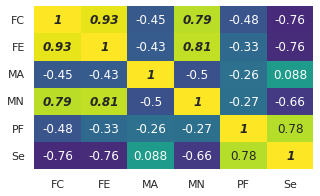

RESULTS
Kendall's W: 0.09848484848484848
Pearson's Rho:
Faithfulness Correlation with baseline_black / Faithfulness Estimate with baseline_black : 0.9260035868266883 (4.287478576917702e-05)
Faithfulness Correlation with baseline_black / Monotonicity Arya with baseline_black : -0.44708939385125057 (0.1679831115247052)
Faithfulness Correlation with baseline_black / Monotonicity Nguyen with baseline_black : 0.7918845509856146 (0.0036736346108320315)
Faithfulness Correlation with baseline_black / Pixel-Flipping with baseline_black : -0.47679410781789333 (0.13812544836325727)
Faithfulness Correlation with baseline_black / Selectivity with baseline_black : -0.7583323762112599 (0.006830522200372861)
Faithfulness Estimate with baseline_black / Monotonicity Arya with baseline_black : -0.429382591549266 (0.18752721135821387)
Faithfulness Estimate with baseline_black / Monotonicity Nguyen with baseline_black : 0.8063868963350624 (0.0027144091171353957)
Faithfulness Estimate with baseline_black / 

In [13]:
plot_same_baseline_diff_metrics_figure(dico_ranks, 'baseline_black')

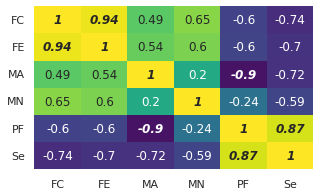

RESULTS
Kendall's W: 0.13080808080808082
Pearson's Rho:
Faithfulness Correlation with baseline_white / Faithfulness Estimate with baseline_white : 0.9386398878115942 (1.8806271013780407e-05)
Faithfulness Correlation with baseline_white / Monotonicity Arya with baseline_white : 0.4903018052365217 (0.12574376202704268)
Faithfulness Correlation with baseline_white / Monotonicity Nguyen with baseline_white : 0.646784516475408 (0.031495625949443974)
Faithfulness Correlation with baseline_white / Pixel-Flipping with baseline_white : -0.6047404210181521 (0.04872452776018993)
Faithfulness Correlation with baseline_white / Selectivity with baseline_white : -0.7439967323707242 (0.008654851995502848)
Faithfulness Estimate with baseline_white / Monotonicity Arya with baseline_white : 0.538103492375632 (0.08772345555916122)
Faithfulness Estimate with baseline_white / Monotonicity Nguyen with baseline_white : 0.604973654892851 (0.04861425181124106)
Faithfulness Estimate with baseline_white / Pixel-F

In [14]:
plot_same_baseline_diff_metrics_figure(dico_ranks, 'baseline_white')

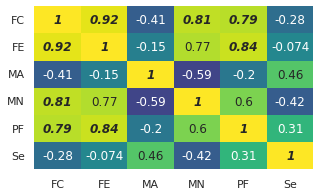

RESULTS
Kendall's W: 0.295959595959596
Pearson's Rho:
Faithfulness Correlation with baseline_random / Faithfulness Estimate with baseline_random : 0.9177185970407219 (6.828183082638902e-05)
Faithfulness Correlation with baseline_random / Monotonicity Arya with baseline_random : -0.4065317450891736 (0.21469737241349365)
Faithfulness Correlation with baseline_random / Monotonicity Nguyen with baseline_random : 0.810965258279563 (0.002454541452616143)
Faithfulness Correlation with baseline_random / Pixel-Flipping with baseline_random : 0.7863377238516093 (0.0040997821180311905)
Faithfulness Correlation with baseline_random / Selectivity with baseline_random : -0.2812594514878142 (0.4021192076722238)
Faithfulness Estimate with baseline_random / Monotonicity Arya with baseline_random : -0.14671861013631188 (0.6668496641282005)
Faithfulness Estimate with baseline_random / Monotonicity Nguyen with baseline_random : 0.7712674231043697 (0.005441964195036637)
Faithfulness Estimate with baseline_

In [15]:
plot_same_baseline_diff_metrics_figure(dico_ranks, 'baseline_random')

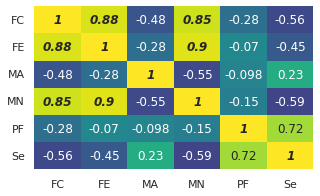

RESULTS
Kendall's W: 0.18181818181818182
Pearson's Rho:
Faithfulness Correlation with baseline_uniform / Faithfulness Estimate with baseline_uniform : 0.883371791364041 (0.00031180598492462386)
Faithfulness Correlation with baseline_uniform / Monotonicity Arya with baseline_uniform : -0.47853932851796277 (0.13648407526934533)
Faithfulness Correlation with baseline_uniform / Monotonicity Nguyen with baseline_uniform : 0.8501900943684633 (0.000915150081994908)
Faithfulness Correlation with baseline_uniform / Pixel-Flipping with baseline_uniform : -0.2750486277637259 (0.4130277123418972)
Faithfulness Correlation with baseline_uniform / Selectivity with baseline_uniform : -0.5583482390877972 (0.07423182299958729)
Faithfulness Estimate with baseline_uniform / Monotonicity Arya with baseline_uniform : -0.2817137540486566 (0.4013269097648901)
Faithfulness Estimate with baseline_uniform / Monotonicity Nguyen with baseline_uniform : 0.9042880541909035 (0.00013217744044510856)
Faithfulness Estim

In [16]:
plot_same_baseline_diff_metrics_figure(dico_ranks, 'baseline_uniform')

## Faithfulness: same metric and different baselines

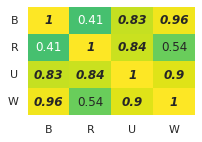

RESULTS
Kendall's W: 0.8113636363636364
Pearson's Rho:
Faithfulness Correlation with baseline_black / Faithfulness Correlation with baseline_random : 0.408819091578971 (0.21187852223615233)
Faithfulness Correlation with baseline_black / Faithfulness Correlation with baseline_uniform : 0.8279114149345828 (0.0016508619081107216)
Faithfulness Correlation with baseline_black / Faithfulness Correlation with baseline_white : 0.9571364829203025 (3.845387016318809e-06)
Faithfulness Correlation with baseline_random / Faithfulness Correlation with baseline_uniform : 0.8414445717133407 (0.0011657531686337073)
Faithfulness Correlation with baseline_random / Faithfulness Correlation with baseline_white : 0.544434728721452 (0.08334273167614234)
Faithfulness Correlation with baseline_uniform / Faithfulness Correlation with baseline_white : 0.9015768944443836 (0.00014927853951427248)


In [17]:
plot_same_metric_diff_baselines_figure(dico_ranks, 'Faithfulness Correlation')

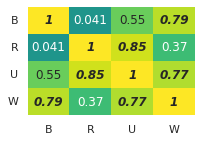

RESULTS
Kendall's W: 0.8045454545454546
Pearson's Rho:
Faithfulness Estimate with baseline_black / Faithfulness Estimate with baseline_random : 0.041226633428252994 (0.9042058477575131)
Faithfulness Estimate with baseline_black / Faithfulness Estimate with baseline_uniform : 0.545615992259554 (0.08254179361151835)
Faithfulness Estimate with baseline_black / Faithfulness Estimate with baseline_white : 0.7925084133977627 (0.0036278471398372087)
Faithfulness Estimate with baseline_random / Faithfulness Estimate with baseline_uniform : 0.8522221329225289 (0.0008632561488766048)
Faithfulness Estimate with baseline_random / Faithfulness Estimate with baseline_white : 0.36966033763228795 (0.2631757975016246)
Faithfulness Estimate with baseline_uniform / Faithfulness Estimate with baseline_white : 0.765037907714811 (0.006081812681474555)


In [18]:
plot_same_metric_diff_baselines_figure(dico_ranks, 'Faithfulness Estimate')

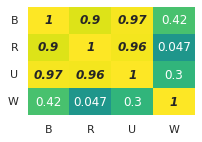

RESULTS
Kendall's W: 0.6988636363636364
Pearson's Rho:
Monotonicity Arya with baseline_black / Monotonicity Arya with baseline_random : 0.8956448179222972 (0.0001925485511685812)
Monotonicity Arya with baseline_black / Monotonicity Arya with baseline_uniform : 0.9739098095687855 (4.219478959832774e-07)
Monotonicity Arya with baseline_black / Monotonicity Arya with baseline_white : 0.4185245680277866 (0.20016325639731428)
Monotonicity Arya with baseline_random / Monotonicity Arya with baseline_uniform : 0.9610323044453424 (2.518699305961271e-06)
Monotonicity Arya with baseline_random / Monotonicity Arya with baseline_white : 0.047082080351758156 (0.8906660732203173)
Monotonicity Arya with baseline_uniform / Monotonicity Arya with baseline_white : 0.3049003197703078 (0.3619281581402332)


In [19]:
plot_same_metric_diff_baselines_figure(dico_ranks, 'Monotonicity Arya')

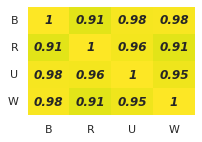

RESULTS
Kendall's W: 0.9215909090909091
Pearson's Rho:
Monotonicity Nguyen with baseline_black / Monotonicity Nguyen with baseline_random : 0.9136355132823466 (8.439847607128202e-05)
Monotonicity Nguyen with baseline_black / Monotonicity Nguyen with baseline_uniform : 0.9758294045850173 (2.999917101541219e-07)
Monotonicity Nguyen with baseline_black / Monotonicity Nguyen with baseline_white : 0.9809214564013505 (1.0422259031478958e-07)
Monotonicity Nguyen with baseline_random / Monotonicity Nguyen with baseline_uniform : 0.9644825738263605 (1.6678903663392394e-06)
Monotonicity Nguyen with baseline_random / Monotonicity Nguyen with baseline_white : 0.908612447760324 (0.00010804072409767657)
Monotonicity Nguyen with baseline_uniform / Monotonicity Nguyen with baseline_white : 0.950024999474557 (7.593333185644662e-06)


In [20]:
plot_same_metric_diff_baselines_figure(dico_ranks, 'Monotonicity Nguyen')

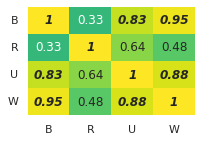

RESULTS
Kendall's W: 0.7681818181818182
Pearson's Rho:
Pixel-Flipping with baseline_black / Pixel-Flipping with baseline_random : 0.33102963534111557 (0.320039650162866)
Pixel-Flipping with baseline_black / Pixel-Flipping with baseline_uniform : 0.8266795707658504 (0.0017015000087137546)
Pixel-Flipping with baseline_black / Pixel-Flipping with baseline_white : 0.9460459479795693 (1.0656875554768126e-05)
Pixel-Flipping with baseline_random / Pixel-Flipping with baseline_uniform : 0.6406885030421735 (0.033676852045754685)
Pixel-Flipping with baseline_random / Pixel-Flipping with baseline_white : 0.4807264728574479 (0.1344445775880968)
Pixel-Flipping with baseline_uniform / Pixel-Flipping with baseline_white : 0.8793460185655209 (0.00036106615710835183)


In [21]:
plot_same_metric_diff_baselines_figure(dico_ranks, 'Pixel-Flipping')

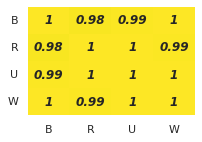

RESULTS
Kendall's W: 0.9875
Pearson's Rho:
Selectivity with baseline_black / Selectivity with baseline_random : 0.9788146400787099 (1.664752486829179e-07)
Selectivity with baseline_black / Selectivity with baseline_uniform : 0.9909858494268894 (3.6221081247948495e-09)
Selectivity with baseline_black / Selectivity with baseline_white : 0.9975206034390095 (1.0975618778397136e-11)
Selectivity with baseline_random / Selectivity with baseline_uniform : 0.9962762023131547 (6.831792754407934e-11)
Selectivity with baseline_random / Selectivity with baseline_white : 0.9882049294861763 (1.2098072817649447e-08)
Selectivity with baseline_uniform / Selectivity with baseline_white : 0.9962720410899715 (6.866173413736637e-11)


In [22]:
plot_same_metric_diff_baselines_figure(dico_ranks, 'Selectivity')

## Complexity

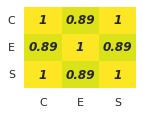

RESULTS
Kendall's W: 0.9414141414141414
Pearson's Rho:
Complexity / EffectiveComplexity : 0.890718870418075 (0.00023522883040620507)
Complexity / Sparseness : 0.9996963191101131 (8.671700214975065e-16)
EffectiveComplexity / Sparseness : 0.8883146067068687 (0.000258500760840706)


In [23]:
selected_metrics = ['Complexity','EffectiveComplexity','Sparseness']
labels = ['Complexity (C)', 'Effective Complexity (E)', 'Sparseness (S)']
short_labels = ['C','E', 'S']
filename = 'final_corr_matrix_rank_aggreg_holm_corr_complexity'
plot_corr_matrix_figure(dico_ranks, selected_metrics, short_labels, short_labels, filename, fig_size=(2,1.5))

## Randomization

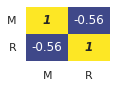

RESULTS
Kendall's W: 0.2909090909090909
Pearson's Rho:
Model Parameter Randomisation / Random Logit : -0.5626933228708151 (0.07152940605524818)


In [24]:
selected_metrics = ['Model Parameter Randomisation', 'Random Logit']
labels = ['Model Parameter Randomisation (M)', 'Random Logit (R)']
short_labels = ['M','R']
filename = 'final_corr_matrix_rank_aggreg_holm_corr_randomization'
plot_corr_matrix_figure(dico_ranks, selected_metrics, short_labels, short_labels, filename, fig_size=(1.5,1))

## Robustness

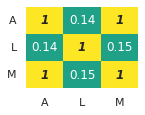

RESULTS
Kendall's W: 0.6202020202020202
Pearson's Rho:
Avg-Sensitivity / Local Lipschitz Estimate : 0.1399440646196522 (0.6815167676460896)
Avg-Sensitivity / Max-Sensitivity : 0.9966384906343404 (4.312482833533691e-11)
Local Lipschitz Estimate / Max-Sensitivity : 0.14685016400011625 (0.6665658607022019)


In [25]:
selected_metrics = ['Avg-Sensitivity','Local Lipschitz Estimate', 'Max-Sensitivity']
labels = ['Avg-Sensitivity (A)', 'Local Lipschitz Estimate (L)', 'Max-Sensitivity (M)']
short_labels = ['A','L', 'M']
filename = 'final_corr_matrix_rank_aggreg_holm_corr_robustness'
plot_corr_matrix_figure(dico_ranks, selected_metrics, short_labels, short_labels, filename, fig_size=(2,1.5))

## All metrics with default baselines (i.e. black)

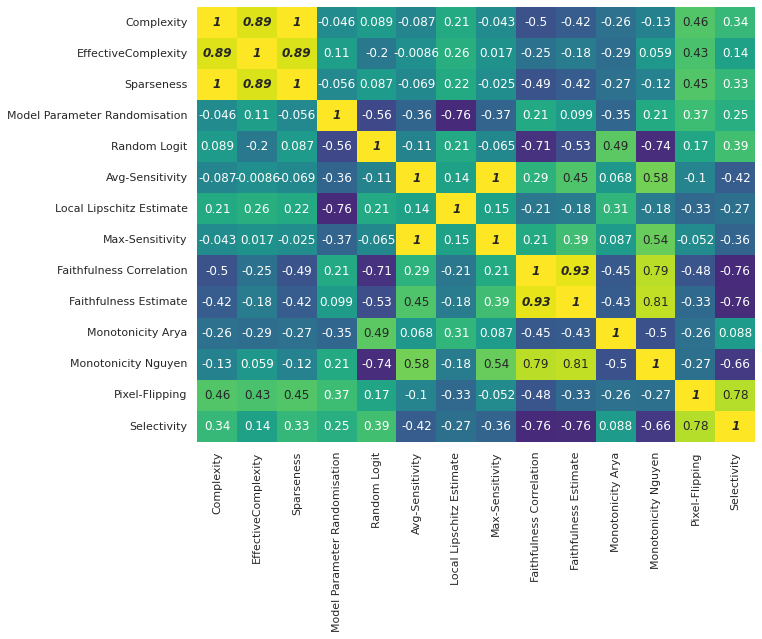

RESULTS
Kendall's W: 0.0673469387755102
Pearson's Rho:
Complexity / EffectiveComplexity : 0.890718870418075 (0.00023522883040620507)
Complexity / Sparseness : 0.9996963191101131 (8.671700214975065e-16)
Complexity / Model Parameter Randomisation : -0.04562757909842619 (0.8940270551038276)
Complexity / Random Logit : 0.08947307444381933 (0.7936218601069536)
Complexity / Avg-Sensitivity : -0.08678320607692196 (0.7997158353058288)
Complexity / Local Lipschitz Estimate : 0.21395342655905483 (0.5275759002407889)
Complexity / Max-Sensitivity : -0.043066692733756684 (0.8999483841047169)
Complexity / Faithfulness Correlation with baseline_black : -0.4958879506747069 (0.12083822281783876)
Complexity / Faithfulness Estimate with baseline_black : -0.4198536039554909 (0.1985899206987491)
Complexity / Monotonicity Arya with baseline_black : -0.2629607737669814 (0.4346639347316883)
Complexity / Monotonicity Nguyen with baseline_black : -0.13139191326499192 (0.7001741542555158)
Complexity / Pixel-Flip

In [26]:
selected_metrics =  [
    'Complexity',
    'EffectiveComplexity',
    'Sparseness',
    'Model Parameter Randomisation',
    'Random Logit',   
    'Avg-Sensitivity',
    'Local Lipschitz Estimate',
    'Max-Sensitivity',
    'Faithfulness Correlation with baseline_black',
    'Faithfulness Estimate with baseline_black',
    'Monotonicity Arya with baseline_black',
    'Monotonicity Nguyen with baseline_black',
    'Pixel-Flipping with baseline_black',
    'Selectivity with baseline_black'    
]

labels = [
    'Complexity',
    'EffectiveComplexity',
    'Sparseness',
    'Model Parameter Randomisation',
    'Random Logit',   
    'Avg-Sensitivity',
    'Local Lipschitz Estimate',
    'Max-Sensitivity',
    'Faithfulness Correlation',
    'Faithfulness Estimate',
    'Monotonicity Arya',
    'Monotonicity Nguyen',
    'Pixel-Flipping',
    'Selectivity'    
]

#for metric in metrics:
#    if metric in metrics_with_different_baselines:
#        selected_metrics.append(f'{metric} with baseline_black')
#    elif metr == 'Model Parameter Randomisation':
#        metr_with_baseline = f'{metr} with bottom_up'
#        final_dico_ranks[metr] = dico_ranks[metr_with_baseline]
#    else:
#        selected_metrics.append(metric)
#    labels.append(metric)

# selected_metrics.sort()
# labels.sort()
filename = 'final_corr_matrix_rank_aggreg_holm_corr_all_metrics_default_baselines'
plot_corr_matrix_figure(dico_ranks, selected_metrics, labels, labels, filename, fig_size=(10,8), rotate_x=False)

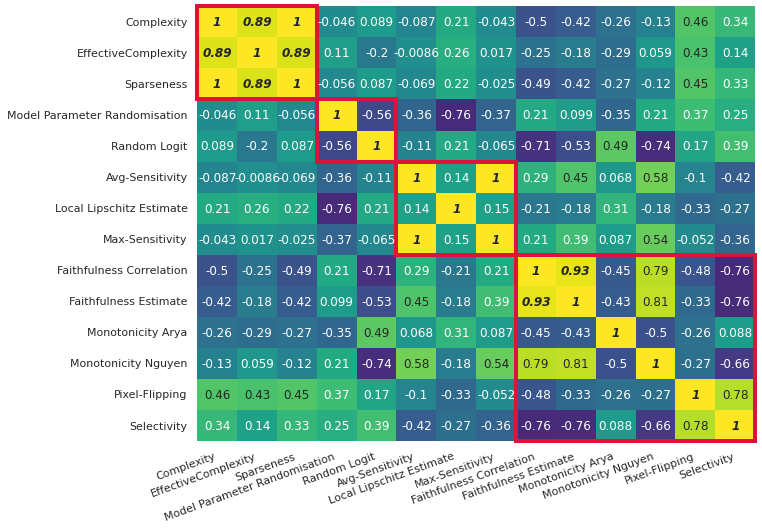

RESULTS
Kendall's W: 0.0673469387755102
Pearson's Rho:
Complexity / EffectiveComplexity : 0.890718870418075 (0.00023522883040620507)
Complexity / Sparseness : 0.9996963191101131 (8.671700214975065e-16)
Complexity / Model Parameter Randomisation : -0.04562757909842619 (0.8940270551038276)
Complexity / Random Logit : 0.08947307444381933 (0.7936218601069536)
Complexity / Avg-Sensitivity : -0.08678320607692196 (0.7997158353058288)
Complexity / Local Lipschitz Estimate : 0.21395342655905483 (0.5275759002407889)
Complexity / Max-Sensitivity : -0.043066692733756684 (0.8999483841047169)
Complexity / Faithfulness Correlation with baseline_black : -0.4958879506747069 (0.12083822281783876)
Complexity / Faithfulness Estimate with baseline_black : -0.4198536039554909 (0.1985899206987491)
Complexity / Monotonicity Arya with baseline_black : -0.2629607737669814 (0.4346639347316883)
Complexity / Monotonicity Nguyen with baseline_black : -0.13139191326499192 (0.7001741542555158)
Complexity / Pixel-Flip

In [27]:
filename = 'final_corr_matrix_rank_aggreg_holm_corr_all_metrics_default_baselines_with_subgroups'
plot_corr_matrix_figure(dico_ranks, selected_metrics, labels, labels, filename, fig_size=(10,8), half_rotate_x=True, subgroups=(3,2,3,6))

## All metrics with all baselines

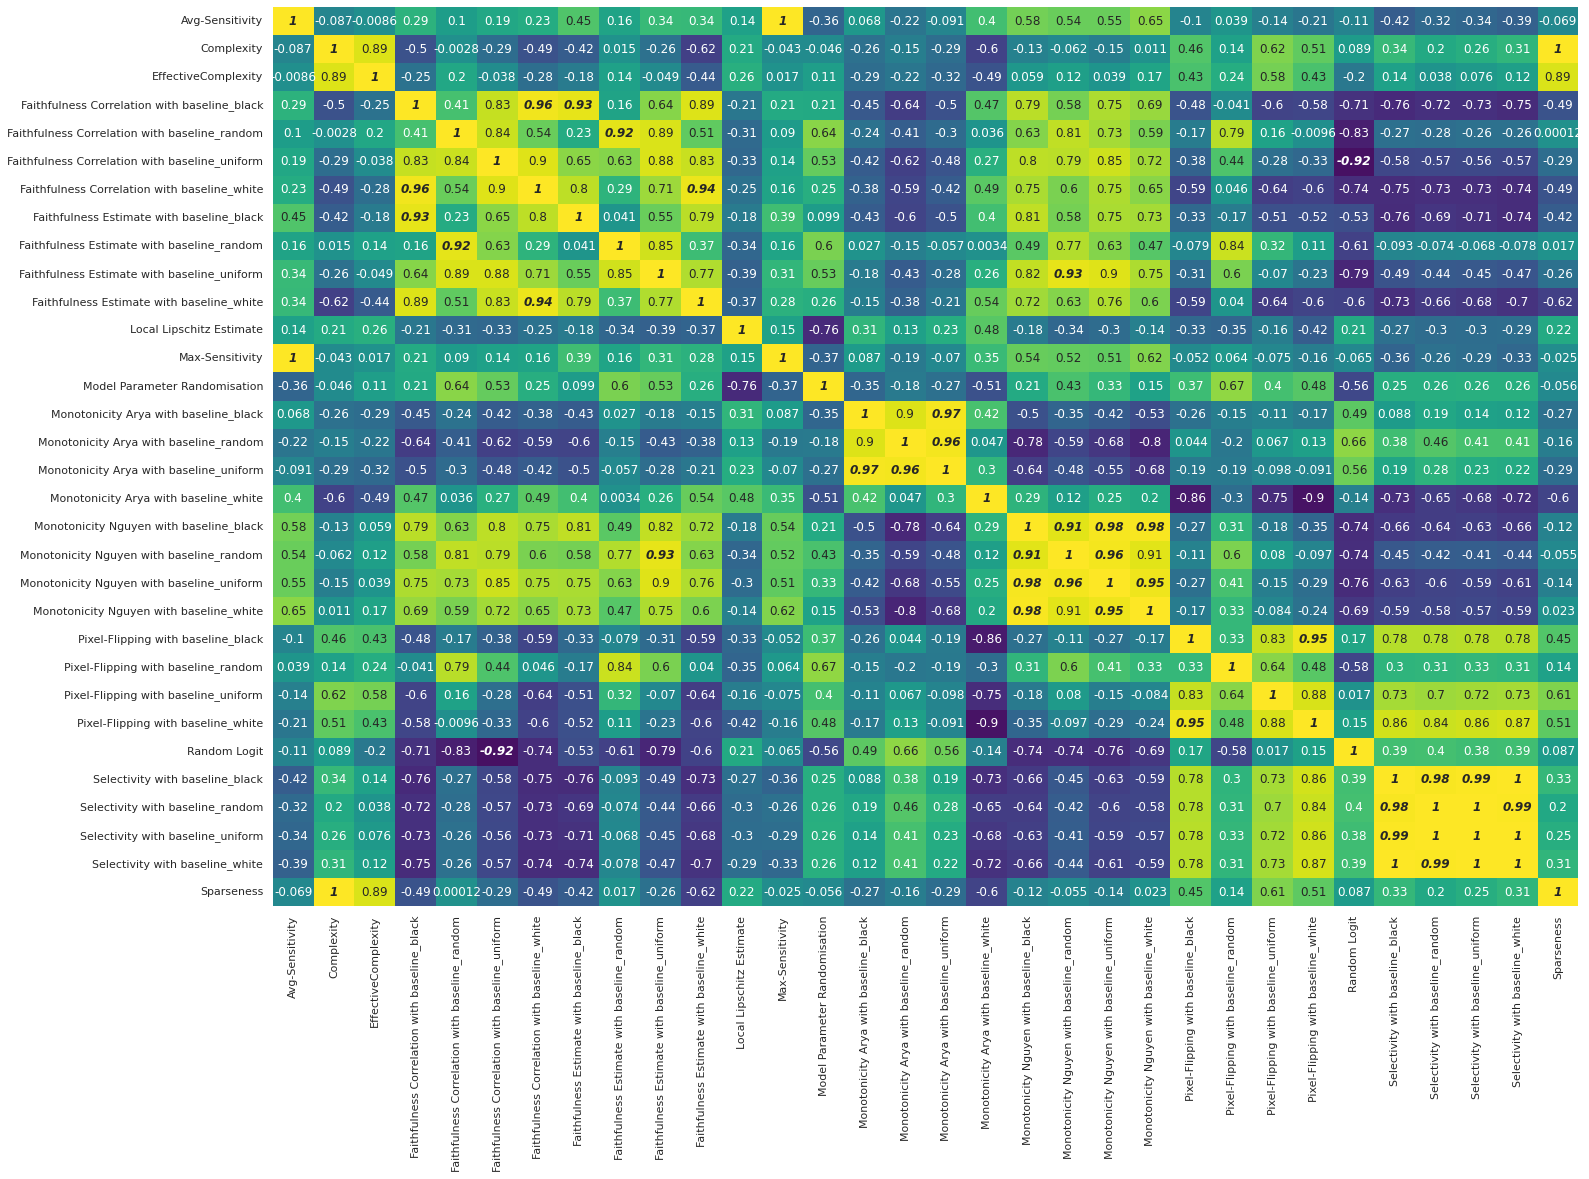

RESULTS
Kendall's W: 0.0712890625
Pearson's Rho:
Avg-Sensitivity / Complexity : -0.08678320607692196 (0.7997158353058288)
Avg-Sensitivity / EffectiveComplexity : -0.008600156817754178 (0.9799787612798408)
Avg-Sensitivity / Faithfulness Correlation with baseline_black : 0.2854251429419964 (0.39488322054525615)
Avg-Sensitivity / Faithfulness Correlation with baseline_random : 0.10386441852840919 (0.7612008207572811)
Avg-Sensitivity / Faithfulness Correlation with baseline_uniform : 0.19049432292871832 (0.5747614065386899)
Avg-Sensitivity / Faithfulness Correlation with baseline_white : 0.2281178854016737 (0.49990247503310276)
Avg-Sensitivity / Faithfulness Estimate with baseline_black : 0.4499205879499102 (0.16497975036181556)
Avg-Sensitivity / Faithfulness Estimate with baseline_random : 0.15779473705457356 (0.643095290007238)
Avg-Sensitivity / Faithfulness Estimate with baseline_uniform : 0.3448348625349369 (0.2990147536340872)
Avg-Sensitivity / Faithfulness Estimate with baseline_whit

In [28]:
selected_metrics = sorted(dico_ranks.keys())
filename = 'final_corr_matrix_rank_aggreg_holm_corr_all_metrics_all_baselines'
plot_corr_matrix_figure(dico_ranks, selected_metrics, selected_metrics, selected_metrics, filename, fig_size=(23.4,16.54), rotate_x=False)